In [1]:
!pip install -r requirements.txt

In [13]:
!python --version


Python 3.7.1


# Importing libraries

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, cross_val_score, train_test_split, cross_val_predict, StratifiedKFold, cross_validate, GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, average_precision_score, roc_curve, accuracy_score, make_scorer, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, precision_recall_curve,average_precision_score, auc,f1_score, make_scorer, recall_score, accuracy_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, brier_score_loss,log_loss
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import time
import itertools
import timeit
import gc


# Understanding Data and objective 

## Objective: Based on a shoppers actions on a website to identify the best prospects who are likely to purchase. 

> In order to understand purchase propensity of site visitiors, we can look at their interactions with website and what is common path to convesion. 

> This will help in re-targeting these folks using custom offers as they will more likley to purchase a product from us. 

## loading data

In [5]:
df_purchase = pd.read_csv('data/Customer_buy_propensity.csv', index_col = False)
print(df_purchase.dtypes)
print(f'unique Value of our Target_class:  {df_purchase.ordered.unique()}')

UserID                     object
basket_icon_click           int64
basket_add_list             int64
basket_add_detail           int64
sort_by                     int64
image_picker                int64
account_page_click          int64
promo_banner_click          int64
detail_wishlist_add         int64
list_size_dropdown          int64
closed_minibasket_click     int64
checked_delivery_detail     int64
checked_returns_detail      int64
sign_in                     int64
saw_checkout                int64
saw_sizecharts              int64
saw_delivery                int64
saw_account_upgrade         int64
saw_homepage                int64
device_mobile               int64
device_computer             int64
device_tablet               int64
returning_user              int64
loc_uk                      int64
ordered                     int64
dtype: object
unique Value of our Target_class:  [0 1]


**We have user_id which  will be unique to a user and rest all are integer values of website actions.** 

## Basic EDA 

In [25]:
print(df_purchase.describe())

print(df_purchase.info())

       basket_icon_click  basket_add_list  basket_add_detail        sort_by  \
count      455401.000000    455401.000000      455401.000000  455401.000000   
mean            0.099150         0.074521           0.112916       0.036849   
std             0.298864         0.262617           0.316490       0.188391   
min             0.000000         0.000000           0.000000       0.000000   
25%             0.000000         0.000000           0.000000       0.000000   
50%             0.000000         0.000000           0.000000       0.000000   
75%             0.000000         0.000000           0.000000       0.000000   
max             1.000000         1.000000           1.000000       1.000000   

        image_picker  account_page_click  promo_banner_click  \
count  455401.000000       455401.000000       455401.000000   
mean        0.026735            0.003570            0.016208   
std         0.161307            0.059647            0.126274   
min         0.000000            

**There are around 450K observations with 25 columns with non-null values**

0    95.807431
1     4.192569
Name: ordered, dtype: float64


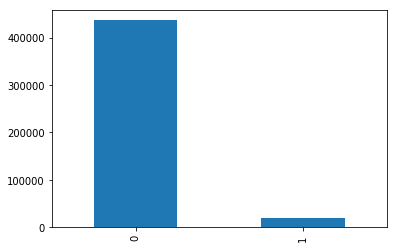

In [34]:
print(df_purchase['ordered'].value_counts()*100.0 /len(df_purchase))
df_purchase['ordered'].value_counts().plot(kind='bar')


#### Out of all site visitiors only ~4% of total population made a purchase. This is high class imbalance problem and we can apply random un dersampling to solve for this when we get into model building

In [36]:
# cooreation between two classes 

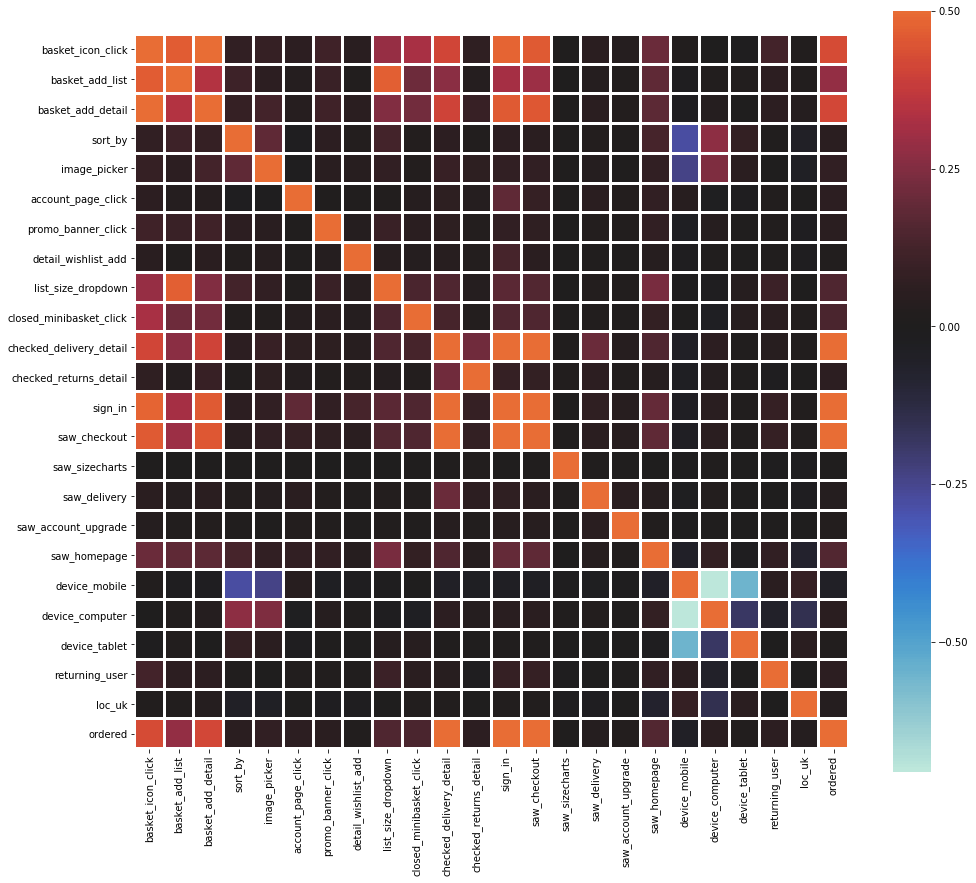

In [40]:
corr = df_purchase.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, vmax=0.5, center=0,
            square=True, linewidths=2)
plt.show()

## Lets focus on Ordered column as we have some strong coorleated variables 

In [42]:
#Correlation with output variable
cor_target = abs(df_purchase.corr()['ordered'])
print(cor_target)


basket_icon_click          0.428334
basket_add_list            0.287666
basket_add_detail          0.414420
sort_by                    0.054636
image_picker               0.071492
account_page_click         0.057279
promo_banner_click         0.056533
detail_wishlist_add        0.023516
list_size_dropdown         0.154867
closed_minibasket_click    0.140011
checked_delivery_detail    0.798720
checked_returns_detail     0.059484
sign_in                    0.665556
saw_checkout               0.708986
saw_sizecharts             0.007548
saw_delivery               0.031461
saw_account_upgrade        0.025857
saw_homepage               0.157778
device_mobile              0.042907
device_computer            0.049208
device_tablet              0.016939
returning_user             0.060295
loc_uk                     0.031643
ordered                    1.000000
Name: ordered, dtype: float64


#### We can see not very strong co-realtion with all orders somein low value, its better to reduce this dataset to build our first model. 

> users who checked out the delivery options on a product detail page have an almost 80% correlation to orders,

# Finding relevant columns with Correaltion over 15% 

In [44]:
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15]
relevant_features

basket_icon_click          0.428334
basket_add_list            0.287666
basket_add_detail          0.414420
list_size_dropdown         0.154867
checked_delivery_detail    0.798720
sign_in                    0.665556
saw_checkout               0.708986
saw_homepage               0.157778
ordered                    1.000000
Name: ordered, dtype: float64

# creating relevant prediction list

In [15]:
predictors_list = ['basket_icon_click','basket_add_list', 'basket_add_detail', 'list_size_dropdown', 
       'checked_delivery_detail', 'sign_in','saw_checkout','saw_homepage']


## undersample dataframe 

In [7]:
# Class count
count_class_0, count_class_1 = df_purchase['ordered'].value_counts()

# Divide by class
df_class_0 = df_purchase[df_purchase['ordered'] == 0]
df_class_1 = df_purchase[df_purchase['ordered'] == 1]

Random under-sampling:
0    19093
1    19093
Name: ordered, dtype: int64


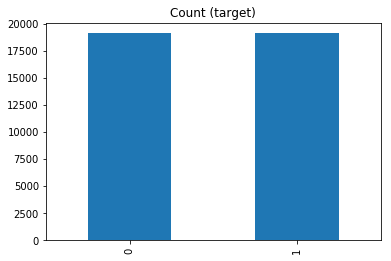

In [16]:
df_class_0_under = df_class_0.sample(count_class_1)
df_purchase_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_purchase_under.ordered.value_counts())

df_purchase_under.ordered.value_counts().plot(kind='bar', title='Count (target)')

#### deleting orginal dataset and use Undersampled data to accound for class imbalance 

In [17]:
del df_purchase
gc.collect()

680

# creating helper functions

In [118]:
def split_data(df,feature_ls, y_target, training: bool = False) -> None:
        """
        Split the data into train, test for model building
        
        returns the Test and train data
        """
        if training:
            df = df.sample(frac=1)
            X_train, X_test, y_train,y_test = train_test_split(df[feature_ls], df[y_target], test_size=0.2, random_state=123) 
            print(X_train.shape,X_test.shape)
            #changing object datatype to int 
            return X_train, X_test, y_train,y_test
        
def get_and_save_metrics(true_labels, pred_labels, y_scores):
    """
    Using Sklearn Metrics, returns dataframe of all the relevant evaluation metrics
    for binary classification. 
    """
    
    accuracy = accuracy_score(true_labels, pred_labels)
    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
    precision_1 = precision_score(true_labels, pred_labels, pos_label=1)
    precision_0 = precision_score(true_labels, pred_labels, pos_label=0)
    recall_1 = recall_score(true_labels, pred_labels, pos_label=1)
    recall_0 = recall_score(true_labels, pred_labels, pos_label=0)
    f1_score_1 = f1_score(true_labels, pred_labels, pos_label=1)

    f1_score_0 = f1_score(true_labels, pred_labels, pos_label=0)
    auc_score = roc_auc_score(true_labels, y_scores)
    metrics = [[accuracy, tn, tp, fn, fp, precision_1, precision_0, recall_1, recall_0, f1_score_1, f1_score_0, auc_score]]
    metrics_df = pd.DataFrame(metrics)
    metrics_df.columns = ['accuracy', 'true_negative', 'true_positive', 'false_negative', 'false_positive',
                          'precision_class_1', 'precision_class_0', 'recall_class_1', 'recall_class_0',
                          'f1_score_class_1', 'f1_score_class_0', 'roc_auc_score']
    return metrics_df


def learning_curve(estimator, X, y, title = "Learning curve"):
    """
    Plotting learning curve by running 3 fold cross validation
    we will be using f-1 score as we have seen there is class imbalance 
    """
    
    f1_train_mean = []
    f1_train_std = []  
    cv_mean = []
    cv_std = []  
    fit_mean = []
    fit_std = []  
    pred_mean = []
    pred_std = []  

    data_size_list = (np.linspace(.05, 1.0, 20) * len(y)).astype('int')

    for len_data in data_size_list:
        index = np.random.randint(X.shape[0], size=len_data)
        sampl_train_data = X.iloc[index, :]
        sampl_train_label = y.iloc[index]
        scores = cross_validate(estimator, sampl_train_data, sampl_train_label, cv=3, scoring='f1', n_jobs=-1, return_train_score=True)

        f1_train_mean.append(np.mean(scores['train_score']))
        f1_train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score']))
        cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time']))
        fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time']))
        pred_std.append(np.std(scores['score_time']))

    f1_train_mean = np.array(f1_train_mean);
    f1_train_std = np.array(f1_train_std)
    cv_mean = np.array(cv_mean);
    cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean);
    fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean);
    pred_std = np.array(pred_std)
    
    
    # plotting Learning curve 
    plt.figure()
    plt.title("Learning curve : " + title)
    plt.xlabel("Training size")
    plt.ylabel("F1 Score")
    plt.fill_between(data_size_list, f1_train_mean - 2 * f1_train_std, f1_train_mean + 2 * f1_train_std, alpha=0.1)
    plt.fill_between(data_size_list, cv_mean - 2 * cv_std, cv_mean + 2 * cv_std, alpha=0.1)
    plt.plot(data_size_list, f1_train_mean, 'o-', label="Training Score")
    plt.plot(data_size_list, cv_mean, 'o-',label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    # plotting time 
    plt.figure()
    plt.title("Time taken by classifier: " + title)
    plt.xlabel("Training size")
    plt.ylabel("Time  in (s)")
    plt.fill_between(data_size_list, fit_mean - 2 * fit_std, fit_mean + 2 * fit_std, alpha=0.1)
    plt.fill_between(data_size_list, pred_mean - 2 * pred_std, pred_mean + 2 * pred_std, alpha=0.1)
    plt.plot(data_size_list, fit_mean, 'o-',  label="Training Time  in (s)")
    plt.plot(data_size_list, pred_std, 'o-', label="Prediction Time in (s)")
    plt.legend(loc="best")
    plt.show()


    # plot_times(data_size_list, fit_mean, fit_std, pred_mean, pred_std, title)

    return f1_train_mean, fit_mean, pred_mean

def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

# fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
# print(auc(fpr, tpr)) # AUC of ROC
# plot_roc_curve(fpr, tpr, 'precision_optimized')

In [18]:
X_train, X_test, y_train, y_test = split_data(df=df_purchase_under,feature_ls=predictors_list, y_target='ordered',training= True)



(30548, 8) (7638, 8)


### Neural Network 

# Neural Network Model complexity based on hidden layer size 

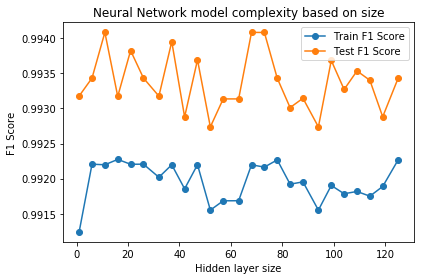

In [22]:
# neural Network Model complexity based on hidden layer size 

f1_score_test = []
f1_score_train = []
h_size = np.linspace(1,125,25).astype('int')
for size in h_size :         
        model = MLPClassifier(hidden_layer_sizes=(size,), solver='adam', activation='logistic', 
                            learning_rate_init=0.05, random_state=100)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        f1_score_train.append(f1_score(y_train, y_pred_train))
        f1_score_test.append(f1_score(y_test, y_pred_test))
        
# plotting model complexity 
plt.plot(h_size, f1_score_train,'o-', label='Train F1 Score')
plt.plot(h_size, f1_score_test, 'o-', label='Test F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Hidden layer size')
plt.title('Neural Network model complexity based on size')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# getting best hyperparameters

In [27]:
def hp_search_nn(X_train, y_train):
    h_units = [5, 10, 20, 30, 40, 50, 60, 75, 100]
    learning_rates = [0.01, 0.05, .1]
    param_space = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

    model_nn = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',random_state=123),
                       param_grid=param_space, cv=3)
    model_nn.fit(X_train, y_train)
    print("best Hyperrameters after 3 fold cv in grid search:")
    print(model_nn.best_params_)
    return model_nn.best_params_['hidden_layer_sizes'], model_nn.best_params_['learning_rate_init']

In [28]:
hl_size, alpha = hp_search_nn(X_train, y_train)

best Hyperrameters after 3 fold cv in grid search:
{'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}


In [33]:
#Training and model metrics using 

In [39]:
# best neural Network 
model_nn = MLPClassifier(hidden_layer_sizes=(hl_size,), solver='adam', activation='logistic', 
                               learning_rate_init=alpha, random_state=123)
# getting evaluation metric on y_test 

start_time = timeit.default_timer()
model_nn.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_nn.predict(X_test)
y_scores = model_nn.predict_proba(X_test)[:,1]
print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 2.396201266999924
Time to score the test data: -0.00017169900002045324
   accuracy  true_negative  true_positive  false_negative  false_positive  \
0  0.993847           3812           3779              16              31   

   precision_class_1  precision_class_0  recall_class_1  recall_class_0  \
0           0.991864            0.99582        0.995784        0.991933   

   f1_score_class_1  f1_score_class_0  roc_auc_score  
0           0.99382          0.993873       0.998006  


In [41]:
# model metrics
get_and_save_metrics(y_test, preds, y_scores)

,accuracy,true_negative,true_positive,false_negative,false_positive,precision_class_1,precision_class_0,recall_class_1,recall_class_0,f1_score_class_1,f1_score_class_0,roc_auc_score
0,0.993847,3812,3779,16,31,0.991864,0.99582,0.995784,0.991933,0.99382,0.993873,0.998006


**On Undersample data we have very high AUC socre along with high f1 score** 

0.9980055450475976


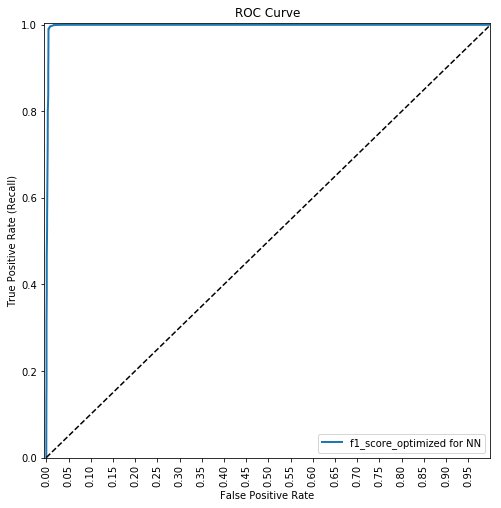

In [43]:
# getting ROC_curve 
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'f1_score_optimized for NN')

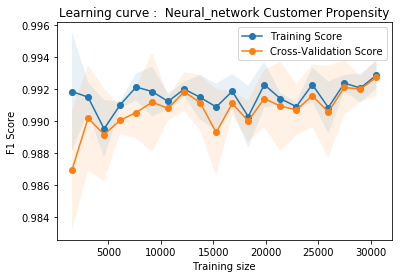

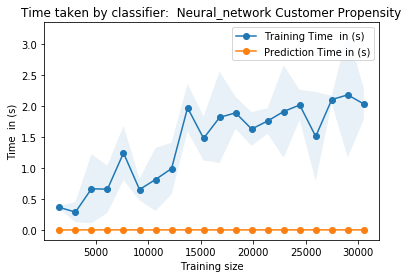

In [68]:
# ploting learning curve and time 
model_nn_train,model_nn_fit_time, model_nn_pred_time = learning_curve(model_nn, X_train, y_train, title= " Neural_network Customer Propensity")

# Support vector Machines(SVM)


### Model complexity based on kernel function: linear, polynomial, rbf (radial basis function) 

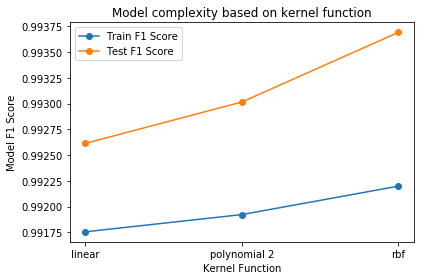

In [75]:
f1_score_test = []
f1_score_train = []
kernel_list = ['linear','poly','rbf']
for kernel in kernel_list:         
        if kernel == 'poly':
            svm_model = SVC(kernel=kernel, degree=2,random_state=123)
            svm_model.fit(X_train, y_train)
            y_pred_train = svm_model.predict(X_train)
            y_pred_test = svm_model.predict(X_test)
            f1_score_train.append(f1_score(y_train, y_pred_train))
            f1_score_test.append(f1_score(y_test, y_pred_test))
        else:    
            svm_model = SVC(kernel=kernel, random_state=123)
            svm_model.fit(X_train, y_train)
            y_pred_test = svm_model.predict(X_test)
            y_pred_train = svm_model.predict(X_train)
            f1_score_train.append(f1_score(y_train, y_pred_train))
            f1_score_test.append(f1_score(y_test, y_pred_test))
            

kernel_type = ['linear','polynomial 2','rbf']
plt.plot(kernel_type, f1_score_train, 'o-',  label='Train F1 Score')
plt.plot(kernel_type, f1_score_test, 'o-', label='Test F1 Score')
plt.ylabel('Model F1 Score')
plt.xlabel('Kernel Function')
plt.title('Model complexity based on kernel function')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# RBF kernel seems to work best so lets use as base SVM and do HP tunning 

In [77]:
def svm_hp_search(X_train, y_train):
    c = [1e-4, 1e-3, 1e-2, 1e01, 1]
    gamma = [1,10,100]
    param_space = {'C': c, 'gamma': gamma}

    svm_model = GridSearchCV(estimator = SVC(kernel='rbf',random_state=123),
                       param_grid=param_space, cv=3)
    svm_model.fit(X_train, y_train)
    print(" best parameters are:")
    print(svm_model.best_params_)
    return svm_model.best_params_['C'], svm_model.best_params_['gamma']

In [ ]:
c_value, gamma = svm_hp_search(X_train, y_train)

In [132]:
print(c_value, gamma)

1 1


In [82]:
model_svm = SVC(C=c_value, gamma=gamma, kernel='rbf')
# getting evaluation metric on y_test 

start_time = timeit.default_timer()
model_svm.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_svm.predict(X_test)

print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 0.7870638449994658
Time to score the test data: -0.0001924050002344302


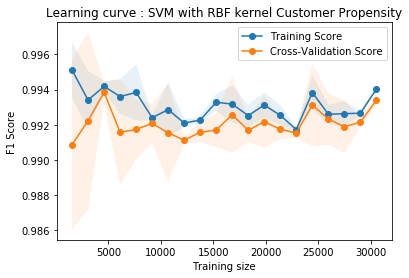

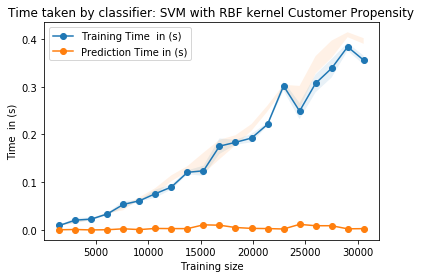

In [83]:
# ploting learning curve and time 
model_svm_train,model_svm_fit_time, model_svm_pred_time = learning_curve(model_svm, X_train, y_train, title= "SVM with RBF kernel Customer Propensity")

# KNN Classifier

> We will only find right Hyperparameter n_neighbours 

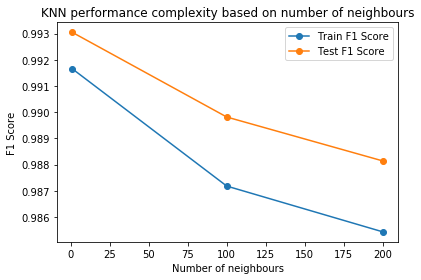

In [87]:
f1_score_test = []
f1_score_train = []
neigh_size = np.linspace(1,200,3).astype('int')
for size in neigh_size :         
        model = kNN(n_neighbors=size,n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        f1_score_train.append(f1_score(y_train, y_pred_train))
        f1_score_test.append(f1_score(y_test, y_pred_test))
        
# plotting model complexity 
plt.plot(neigh_size, f1_score_train,'o-', label='Train F1 Score')
plt.plot(neigh_size, f1_score_test, 'o-', label='Test F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Number of neighbours')
plt.title('KNN performance complexity based on number of neighbours')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [88]:
#model prediction using KNN 

model_knn = kNN(n_neighbors=3, n_jobs=-1)
# getting evaluation metric on y_test 

start_time = timeit.default_timer()
model_knn.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_knn.predict(X_test)
print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 0.67073604000052
Time to score the test data: -0.0002492339999662363


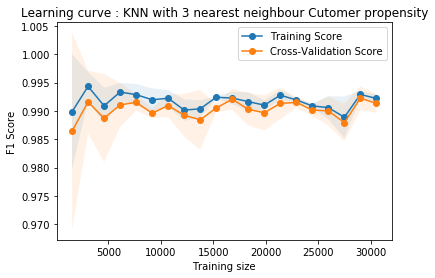

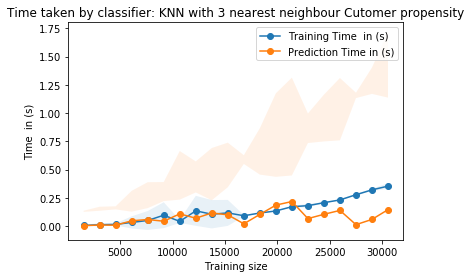

In [94]:
# ploting learning curve and time 
model_knn_train,model_knn_fit_time, model_knn_pred_time = learning_curve(model_knn, X_train, y_train, title= "KNN with 3 nearest neighbour Cutomer propensity")

# Decision_Tree

### doing puining by setting max_depth parameter 

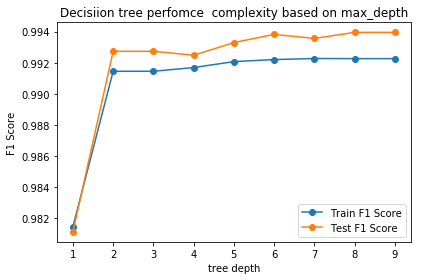

In [96]:
f1_score_test = []
f1_score_train = []
tree_depth = list(range(1,10))
for sp in tree_depth:         
        model = DecisionTreeClassifier(max_depth=sp, min_samples_leaf=1, criterion='entropy')
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        f1_score_train.append(f1_score(y_train, y_pred_train))
        f1_score_test.append(f1_score(y_test, y_pred_test))
        
# plotting model complexity 
plt.plot(tree_depth, f1_score_train,'o-', label='Train F1 Score')
plt.plot(tree_depth, f1_score_test, 'o-', label='Test F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('tree depth')
plt.title('Decisiion tree perfomce  complexity based on max_depth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# search CV 


In [98]:
def dt_hp_search(X_train, y_train):
    param_space = {'min_samples_leaf':np.linspace(round(0.005*len(X_train)), round(0.05*len(X_train)),20).round().astype('int'), 'max_depth':np.arange(1,10)}

    model_dt = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_space, cv=3)
    model_dt.fit(X_train, y_train)
    print("best parameters are:")
    print(model_dt.best_params_)
    return model_dt.best_params_['max_depth'], model_dt.best_params_['min_samples_leaf']

In [99]:
max_depth, min_leaf = dt_hp_search(X_train,y_train)
model_dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_leaf, criterion='entropy')

best parameters are:
{'max_depth': 2, 'min_samples_leaf': 153}


In [100]:
start_time = timeit.default_timer()
model_dt.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_dt.predict(X_test)
y_scores = model_dt.predict_proba(X_test)[:,1]
print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 0.008303479999995034
Time to score the test data: -0.000170592000358738


In [101]:
# model metrics
get_and_save_metrics(y_test, preds, y_scores)

,accuracy,true_negative,true_positive,false_negative,false_positive,precision_class_1,precision_class_0,recall_class_1,recall_class_0,f1_score_class_1,f1_score_class_0,roc_auc_score
0,0.992799,3824,3759,36,19,0.994971,0.990674,0.990514,0.995056,0.992737,0.99286,0.997348


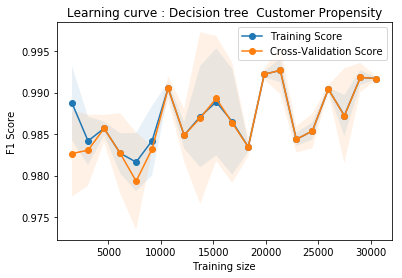

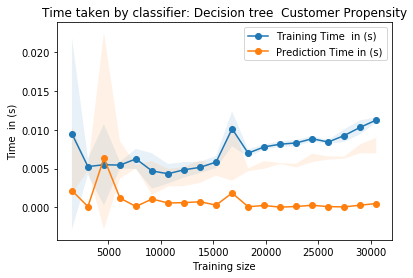

In [121]:
# ploting learning curve and time 
model_dt_train,model_dt_fit_time, model_dt_pred_time = learning_curve(model_dt, X_train, y_train, title= "Decision tree  Customer Propensity")

0.9973477777469224


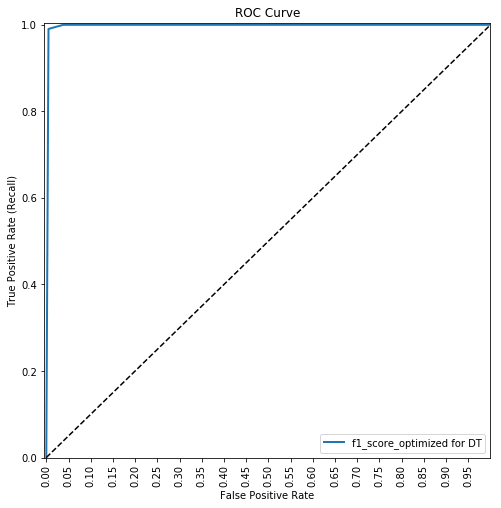

In [103]:
# getting ROC_curve 
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'f1_score_optimized for DT')

# Gradient Boosting
## Hyperparamter training 


In [111]:
def gbt_hp_search( X_train, y_train):

    param_space = {'min_samples_leaf':np.linspace(round(0.005*len(X_train)), round(0.05*len(X_train)),20).round().astype('int'),
                  'max_depth': list(range(1,5)),
                  'n_estimators': np.linspace(10,200,3).round().astype('int'),
                  'learning_rate': [.001,0.05, 0.1]}

    model_gbt = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_space, cv=3)
    model_gbt.fit(X_train, y_train)
    print("Best parameters are:")
    print(model_gbt.best_params_)
    return model_gbt.best_params_['max_depth'],model_gbt.best_params_['min_samples_leaf'], model_gbt.best_params_['n_estimators'],model_gbt.best_params_['learning_rate']

In [112]:
max_depth, min_leaf, n_est, alpha= gbt_hp_search(X_train,y_train)

Best parameters are:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 298, 'n_estimators': 200}


In [114]:
model_gbt = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_leaf, 
                                              n_estimators=n_est, learning_rate=alpha)

In [115]:
start_time = timeit.default_timer()
model_gbt.fit(X_train, y_train)
end_time = timeit.default_timer()

print(f"training_time to fit the model: {end_time - start_time}")    
start_time = timeit.default_timer()    
preds = model_gbt.predict(X_test)
y_scores = model_dt.predict_proba(X_test)[:,1]
print(f"Time to score the test data: {end_time - start_time}")  



training_time to fit the model: 2.172035509000125
Time to score the test data: -0.0002564329988672398


In [116]:
# model metrics
get_and_save_metrics(y_test, preds, y_scores)

,accuracy,true_negative,true_positive,false_negative,false_positive,precision_class_1,precision_class_0,recall_class_1,recall_class_0,f1_score_class_1,f1_score_class_0,roc_auc_score
0,0.993977,3812,3780,15,31,0.991866,0.99608,0.996047,0.991933,0.993952,0.994003,0.997348


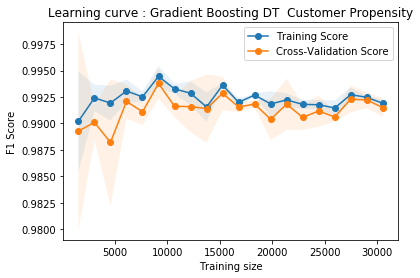

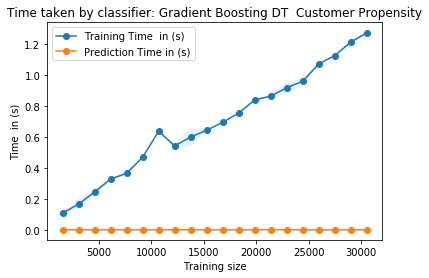

In [119]:
# ploting learning curve and time 
model_gbt_train,model_gbt_fit_time, model_gbt_pred_time = learning_curve(model_gbt, X_train, y_train, title= "Gradient Boosting DT  Customer Propensity")

0.9973477777469224


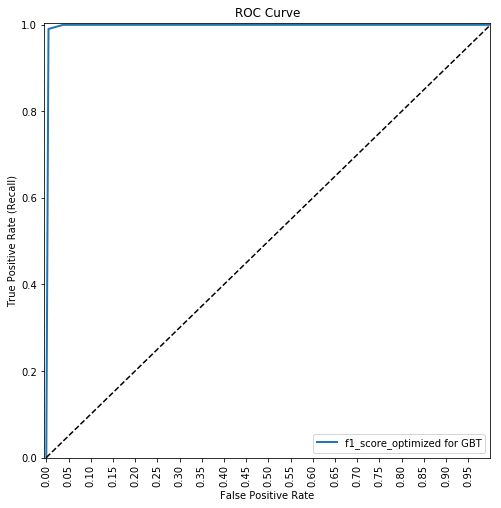

In [120]:
# getting ROC_curve 
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'f1_score_optimized for GBT')

# model comparison metrics 

1. Model fitting Time

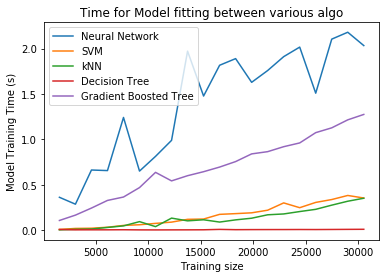

In [127]:
data_size = (np.linspace(.05, 1.0, 20) * len(y_train)).astype('int')
plt.figure()
plt.title("Time for Model fitting between various algo: Customer Propensity")
plt.xlabel("Training size")
plt.ylabel("Model Training Time (s)")
plt.plot(data_size, model_nn_fit_time, '-', label="Neural Network")
plt.plot(data_size, model_svm_fit_time, '-', label="SVM")
plt.plot(data_size, model_knn_fit_time, '-', label="kNN")
plt.plot(data_size, model_dt_fit_time, '-', label="Decision Tree")
plt.plot(data_size, model_gbt_fit_time, '-', label="Gradient Boosted Tree")
plt.legend(loc="best")
plt.show()

2. Model Inference_time

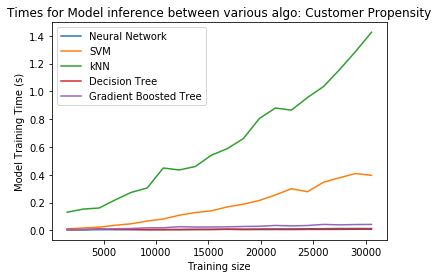

In [131]:

plt.figure()
plt.title("Times for Model inference between various algo: Customer Propensity")
plt.xlabel("Training size")
plt.ylabel("Model Training Time (s)")
plt.plot(data_size, model_nn_pred_time, '-', label="Neural Network")
plt.plot(data_size, model_svm_pred_time, '-', label="SVM")
plt.plot(data_size, model_knn_pred_time, '-', label="kNN")
plt.plot(data_size, model_dt_pred_time, '-', label="Decision Tree")
plt.plot(data_size, model_gbt_pred_time, '-', label="Gradient Boosted Tree")
plt.legend(loc="best")
plt.show()

3. Model Performance f1 score


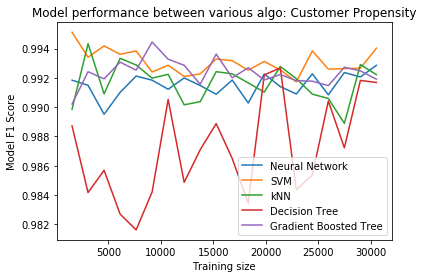

In [130]:
plt.figure()
plt.title("Model performance between various algo: Customer Propensity")
plt.xlabel("Training size")
plt.ylabel("Model F1 Score")
plt.plot(data_size, model_nn_train, '-', label="Neural Network")
plt.plot(data_size, model_svm_train, '-', label="SVM")
plt.plot(data_size, model_knn_train, '-', label="kNN")
plt.plot(data_size, model_dt_train, '-', label="Decision Tree")
plt.plot(data_size, model_gbt_train, '-', label="Gradient Boosted Tree")
plt.legend(loc="best")
plt.show()